In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

## Exploratory Data Analysis and Preproccessing

In [2]:
# import tweets
tweets = pd.read_csv("../data/Tweets_historical/historic_tweets_07232019.csv")

In [3]:
tweets.head()

,date,geo,hashtags,id,text,type,username
0,2016-11-28 20:53:31+00:00,NaN,NaN,803341071266811904,321 Northbound at exit 20 is shutdown to this ...,official,chrisWSOC9
1,2016-11-19 01:55:52+00:00,NaN,NaN,799793282498838528,Just your typical 34-28 halftime score here at...,official,chrisWSOC9
2,2016-11-19 01:39:01+00:00,NaN,NaN,799789040421765122,Hey stop me if you heard this but Marvin Ridge...,official,chrisWSOC9
3,2016-11-19 01:34:38+00:00,NaN,NaN,799787940222300160,No worries Concord scored in like a min. Still...,official,chrisWSOC9
4,2016-11-19 01:31:57+00:00,NaN,NaN,799787261617389568,Whoever wins this Concord/Marvin Ridge game wi...,official,chrisWSOC9


In [4]:
# define function to plot count of words after count vectorization
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(8,4))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

In [5]:
# define function to run regex startments over a column labeled "text"
def twt_preprocess(twt):
    # run regex to remove urls
    twt['text'] = twt['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove certain characters
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[@\?\.$%_\[\]()+-:*\"]", ' ', x, flags=re.I))
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[,']", '', x, flags=re.I))
    twt['text'] = twt['text'].map(lambda x: re.sub("(?<![\w'])\w+?(?=\b|'s)", ' ', x))

    # run regex to remove line breaks and tabs
    twt['text'] = twt['text'].map(lambda x: re.sub(r"\s+", ' ', x))

    # run regex to remove common words
    twt['text'] = twt['text'].map(lambda x: re.sub('(twitter|ly|pic|bit)[s]?', ' ', x,  flags=re.I))   

In [6]:
# run regex cleaner on full dataframe
twt_preprocess(tweets)

In [18]:
# establish list of words to search for in dataframe
road_keywords = ['road closed', 'remains closed', 'closed', 'no travel', 'delay', 'accident', 'emergency', 'crash']

In [45]:
# define function to filter the full dataframe for tweets that contain words from a keyword list
def road_filter (df, col, keywords):
    query = []
    for word in keywords:
        mask = df[col].str.contains(word, regex=False, case=False)
        query.append(mask)
    filter_df = df[np.any(query, axis=0)]
    return filter_df

In [48]:
# run function on full dataframe
twitter_closures = road_filter(tweets, 'text', road_keywords)

In [49]:
# find which accounts had information about road closures
twitter_closures['username'].value_counts()

WTOPtraffic        2079
NCDOT_Triangle     1775
fl511_northeast    1177
WOKVNews           1108
TotalTrafficJAX     758
SCDOTLowCountry     571
ActionTraffic       251
ActionNewsJax       201
wsoctv              183
511Georgia          180
wsbtv               139
WRAL                 96
postandcourier       73
NCEmergency          71
SCEMD                70
newsobserver         70
jaxdotcom            61
FLSERT               56
NCPublicSafety       54
ChathamEMA           51
NCDOT                46
SavPolice            45
NCSHP                44
GADeptofTrans        40
cityofsavannah       29
scdhec               20
CDCemergency         12
ChasCoSheriff        12
VDEM                 11
ChasCountyGov        10
NWSCharlestonSC      10
GeorgiaEMA            9
GeorgiaPower          9
kenlemonWSOC9         9
FahertyWSOC9          9
CityCharleston        6
femaregion4           4
NWSWilmingtonNC       4
NWSGSP                3
GlynnCounty           3
NWS                   3
SCDPS_PIO       

In [38]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(twitter_closures['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(9376, 4255)


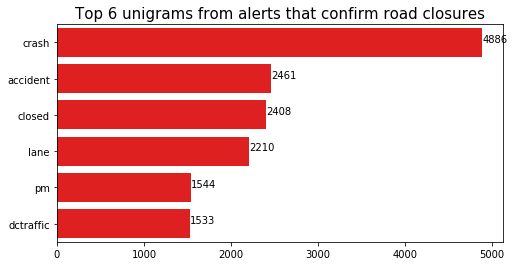

In [39]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from alerts that confirm road closures','r')